# Brain Tumor Segmentation using U-Net architecture.
  U-Net Official paper : [Submitted on 18 May 2015 to arxiv.org](https://arxiv.org/abs/1505.04597)<br>
  Dataset Used : [Submitted on 03 April 2017 by Jun Cheng](https://figshare.com/articles/brain_tumor_dataset/1512427)<br>
  Primary Deeplearning Framework Used: [Pytorch by Facebook AI](https://pytorch.org/)
  
  Contents:<br>
  - [Library Imports](#Library-Imports)
  - [Hyperparameters Tuning](#Hyperparameters-Tuning)
  - [Dataset Loading](#Dataset-Loading)
  - [Model Declaration](#Model-Declaration)
  - [Model Training](#Model-Training)
  - [Training Results](#Training-Results)
      - [Training Loss Graph](#Training-Loss-Graph)
      - [Prediction Visualization](#Visualize-Test-Dataset-Predictions)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Brain-Tumor-Segmentation

/content/drive/MyDrive/Brain-Tumor-Segmentation


## Library Imports

In [3]:
!pip install TensorBoardX

In [4]:
!pip install -r requirements.txt

  Using cached h5py-2.9.0.tar.gz (287 kB)
  Preparing metadata (setup.py) ... done
  Using cached jupyterlab-0.35.4-py3-none-any.whl (14.7 MB)
  Using cached matplotlib-3.0.2.tar.gz (36.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.16.1.zip (5.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached Pillow-8.1.1.tar.gz (45.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached requests-2.21.0-py2.py3-none-any.whl (57 kB)
  Using cached tensorboardX-1.6-py2.py3-none-any.whl (129 kB)
  Using cached tqdm-4.19.9-py2.py3-none-any.whl (52 kB)
ERROR: Could not find a version that satisfies the requirement torch==1.0.1 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1)
ERROR: No matching distribution found for torch==1.0.1


In [5]:
import os
import warnings
import pickle
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import SubsetRandomSampler

import numpy as np
%matplotlib inline

import bts.dataset as dataset
import bts.model as model
import bts.classifier as classifier
import bts.plot as plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

# To Start TensorBoard
# tensorboard --logdir logs --samples_per_plugin images=200

Computation Details
	Device Used: (cuda)  Tesla V100-SXM2-16GB

Packages Used Versions:-
	Pytorch Version: 2.1.0+cu121


In [6]:
#seed 고정
torch.manual_seed(42)

## Hyperparameters Tuning

In [7]:
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Dataset folder used
DATASET_USED = 'png_dataset'
# Full Dataset path
DATASET_PATH = os.path.join('/content/drive/MyDrive/Brain-Tumor-Segmentation/datastet/',DATASET_USED)
# Training Epochs
EPOCHS = 150
# Filters used in UNet Model
FILTER_LIST = [16, 32, 64, 128, 256]
# Flag to train the model
TRAIN = True
# Flag to load saved model
LOAD_MODEL = False
# Flag to save model trained
SAVE_MODEL = True
#NAME
NAME = "BCEDice"
# Model name to save or load.
MODEL_NAME = f"UNet2-{NAME}-{EPOCHS}.pt" #change

print(f"Model Name :   {MODEL_NAME}")

Model Name :   UNet2-BCEDice-150.pt


## Dataset Loading

In [8]:
def get_indices(length, new=False):
    """ Gets the Training & Testing data indices for a
    particular "DATASET_USED". Stores the indices and returns
    them back when the same dataset is used.
    Parameters:
        length(int): Length of the dataset used.
        new(bool): Discard the saved indices and get new ones.
    Return:
        train_indices(list): Array of indices used for training purpose.
        test_indices(list): Array of indices used for testing purpose.
    """
    # Pickle file location of the indices.
    file_path = '/content/drive/MyDrive/Brain-Tumor-Segmentation/datastet/split_indices_png_dataset.p'
    data = dict()
    if os.path.isfile(file_path) and not new:
        # File found.
        print("File Found")
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            return data['train_indices'], data['val_indices'], data['test_indices']
    else:
        print("New File")
        # File not found or fresh copy is required.
        indices = list(range(length))
        np.random.shuffle(indices)

        train_split = 0.6
        val_split = 0.2
        test_split = 0.2

        train_split_index = int(np.floor(train_split * length))
        val_split_index = int(np.floor((train_split + val_split) * length))

        train_indices = indices[:train_split_index]
        val_indices = indices[train_split_index:val_split_index]
        test_indices = indices[val_split_index:]

        # Save data to dictionary
        data['train_indices'] = train_indices
        data['val_indices'] = val_indices
        data['test_indices'] = test_indices

        with open(file_path, 'wb') as file:
            pickle.dump(data, file)

        return train_indices, val_indices, test_indices

In [9]:
tumor_dataset = dataset.TumorDataset(DATASET_PATH)

train = '/content/drive/MyDrive/Brain-Tumor-Segmentation/train'
valid = '/content/drive/MyDrive/Brain-Tumor-Segmentation/validation'
test = '/content/drive/MyDrive/Brain-Tumor-Segmentation/test'

from torch.utils.data import RandomSampler, DataLoader

train_data = dataset.TumorDataset(train,transform = False)
valid_data = dataset.TumorDataset(valid)
test_data = dataset.TumorDataset(test)

train_indices, val_indices, test_indices = get_indices(len(tumor_dataset), new=False)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = train_sampler)
valloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, sampler = val_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, sampler = test_sampler)


File Found


## Model Declaration

In [11]:
import bts.dataset as dataset
import bts.model as model
import bts.classifier as classifier
import bts.plot as plot

unet_model = None
unet_classifier = None
if not LOAD_MODEL:
    # New model is created.
    unet_model = model.DynamicUNet(FILTER_LIST).to(device)
    unet_model = model.ResUNet(1).to(device)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
else:
    # Saved model is loaded on memory.
    unet_model = model.DynamicUnet(FILTER_LIST).to(device)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
    unet_classifier.restore_model(os.path.join('saved_models',MODEL_NAME))
    print('Saved model loaded')

#### Uncomment this section if visualization of training progress is required on Tensorboard

In [12]:
"""
till = 8
choice = test_indices[:till]
sample = list()
for _ in range(till):
    sample.append(dataset[choice[_]])
"""

'\ntill = 8\nchoice = test_indices[:till]\nsample = list()\nfor _ in range(till):\n    sample.append(dataset[choice[_]])\n'

## Model Training

In [13]:
import bts.loss as loss
import bts.classifier as classifier

In [ ]:
# Training process
if TRAIN:
    unet_model.train()
    path = os.path.join('saved_models',MODEL_NAME) if SAVE_MODEL else None
    unet_train_history = unet_classifier.train(EPOCHS,trainloader,valloader,mini_batch=100,save_best=path)
    print(f'Training Finished after {EPOCHS} epoches')


Starting Training Process
Epoch: 001,  Train Loss:0.2529652,  Validation Loss:0.2003582,  Time:20.97secs	Saved at validation loss: 0.2003581623
Epoch: 002,  Train Loss:0.1825342,  Validation Loss:0.1283870,  Time:20.57secs	Saved at validation loss: 0.1283870022
Epoch: 003,  Train Loss:0.1218085,  Validation Loss:0.1515443,  Time:20.73secs
Epoch: 004,  Train Loss:0.1093847,  Validation Loss:0.1092062,  Time:20.47secs	Saved at validation loss: 0.1092062116
Epoch: 005,  Train Loss:0.1011326,  Validation Loss:0.1083323,  Time:20.58secs	Saved at validation loss: 0.1083323270
Epoch: 006,  Train Loss:0.0943427,  Validation Loss:0.1468007,  Time:20.55secs
Epoch: 007,  Train Loss:0.1007223,  Validation Loss:0.1016295,  Time:20.49secs	Saved at validation loss: 0.1016294867
Epoch: 008,  Train Loss:0.0926364,  Validation Loss:0.1055071,  Time:20.58secs
Epoch: 009,  Train Loss:0.0837364,  Validation Loss:0.0965804,  Time:20.53secs	Saved at validation loss: 0.0965804140
Epoch: 010,  Train Loss:0.083

In [ ]:
#Testing process on test data.
unet_model.eval()
mean_dice_score, mean_iou_score = unet_classifier.test(testloader)
print(f'\n\nDice Score {mean_dice_score} \n\nIOU Score {mean_iou_score}')



Dice Score 0.7232843637466431 

IOU Score 0.6269475396048246


## Training Results

### Training Loss Graph

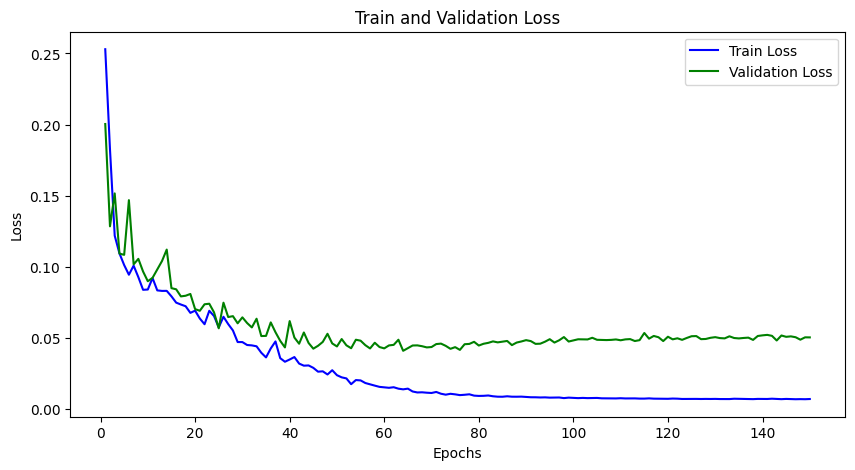

In [ ]:
import matplotlib.pyplot as plt

def plot_train_valid_loss(train_loss, valid_loss):
    """Plot training and validation loss"""
    epochs = len(train_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_loss,'b', label='Train Loss')
    plt.plot(range(1, epochs + 1), valid_loss,'g', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_train_valid_loss(unet_train_history['train_loss'], unet_train_history['val_loss'])

### Visualize Test Dataset Predictions
Run the 2nd cell to get new predictions of different data

In [ ]:
dir = f'UNet2_{EPOCHS}_{NAME}'
os.makedirs(dir)

In [ ]:
for i in range(len(test_indices)):
  image_index = test_indices[i]
  sample = tumor_dataset[image_index]
  image, mask, output, d_score, iou_score = unet_classifier.predict(sample,0.65)
  title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}   IOU Score: {iou_score:.5f}'
  save_path = os.path.join(dir,f'{d_score:.5f}_{image_index}.png')
  plot.result(image,mask,output,title,save_path=save_path)
